This study explores the application of machine learning techniques to classify fashion items using the Fashion MNIST dataset. The dataset consists of grayscale images representing different types of clothing, making it a suitable challenge for computer vision tasks. The analysis begins with data preprocessing, including standardization and train-test splitting, to ensure that the models are evaluated on unseen data. Exploratory Data Analysis (EDA) provides insights into the dataset's distribution and consistency. Several machine learning models are implemented, including Support Vector Machines (SVM) and Principal Component Analysis (PCA) for dimensionality reduction. Additionally, hyperparameter tuning using GridSearchCV is applied to optimize model performance. The results are assessed based on accuracy, confusion matrices, and classification reports, providing a comprehensive evaluation of each model's predictive capabilities. This study highlights the importance of feature scaling and model selection in achieving robust classification performance in image recognition tasks.

# Import libraries

In order to run all the chosen tests in the data, the first thing that has to be done is importing all the nessesary libraries.

In [ ]:
# Import tensorflow
import tensorflow as tf

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

# Load and splitting the data

Given that we will be creating models, it is important to made the data splits inn the earlier stages of the inverstigation. To ensure that the models can be tested with unseen data.

In [ ]:
# Split the data into training and test
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# EDA and checking consistency

Before we can begin creating the models, it is important to conduct EDA to ensure that the models can be made.

In [ ]:
# Concatenate train and test labels
all_labels = np.concatenate((y_train, y_test))

# Calculate class counts
class_counts = np.bincount(all_labels)

# Print class counts
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples")

Class 0: 7000 samples
Class 1: 7000 samples
Class 2: 7000 samples
Class 3: 7000 samples
Class 4: 7000 samples
Class 5: 7000 samples
Class 6: 7000 samples
Class 7: 7000 samples
Class 8: 7000 samples
Class 9: 7000 samples


In [ ]:
# Convert to DataFrame
df_train = pd.DataFrame({"label": y_train})
df_test = pd.DataFrame({"label": y_test})
# Get class distribution
class_distribution = df_train["label"].value_counts().sort_index()
class_distribution_test = df_test["label"].value_counts().sort_index()
print(class_distribution)
print(class_distribution_test)

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64
label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64


From these cells we gathered the total counts for each class, and firgured that the data could be decribed as balanced.

In [ ]:
# Calculate average pixel values for train set
average_pixel_train = np.mean(x_train, axis=(1, 2))
# Calculate average pixel values for test set
average_pixel_test = np.mean(x_test, axis=(1, 2))

df_train['average_pixel'] = average_pixel_train
df_test['average_pixel'] = average_pixel_test

print(df_train.head())
print(df_test.head())

   label  average_pixel
0      9      97.253827
1      0     107.905612
2      0      36.558673
3      3      59.501276
4      0      78.044643
   label  average_pixel
0      9      42.673469
1      2     128.818878
2      1      65.714286
3      1      45.123724
4      6      79.917092


Here, we have created a new column "average_pixel" that contains the average pixel value for the impages both in the training and testing sets. This new column was created with the purpose of being used to improve the model and help it better identify the images benign shown, as there are specific images that will contain different ammount of pixels.

In [ ]:
# Calculate the mean of average pixel values for each class in the training set
mean_avg_pixel_per_class_train = df_train.groupby('label')['average_pixel'].mean()

# Calculate the mean of average pixel values for each class in the test set
mean_avg_pixel_per_class_test = df_test.groupby('label')['average_pixel'].mean()


print("Mean average pixel per class (training set):")
print(mean_avg_pixel_per_class_train)

print("\nMean average pixel per class (test set):")
print(mean_avg_pixel_per_class_test)

Mean average pixel per class (training set):
label
0    83.029980
1    56.840855
2    96.058763
3    66.018909
4    98.258006
5    34.867547
6    84.605120
7    42.762072
8    90.157153
9    76.805118
Name: average_pixel, dtype: float64

Mean average pixel per class (test set):
label
0    83.623657
1    56.981408
2    95.352675
3    66.395017
4    99.745092
5    34.757332
6    84.858413
7    43.019793
8    90.138944
9    76.593335
Name: average_pixel, dtype: float64


In [ ]:
# Calculate descriptive statistics for each class's mean average pixel
def calculate_descriptive_stats(df, label_col='label', pixel_col='average_pixel'):
    descriptive_stats = df.groupby(label_col)[pixel_col].agg(['mean', 'std', 'min', 'max', 'median', 'count'])
    return descriptive_stats

# Calculate descriptive statistics for the training set
train_stats = calculate_descriptive_stats(df_train)
print("Descriptive statistics for training set:")
print(train_stats)

# Calculate descriptive statistics for the test set
test_stats = calculate_descriptive_stats(df_test)
print("\nDescriptive statistics for test set:")
print(test_stats)


Descriptive statistics for training set:
            mean        std        min         max      median  count
label                                                                
0      83.029980  28.913013   9.753827  186.316327   86.665179   6000
1      56.840855  14.523718  15.128827  177.750000   56.371811   6000
2      96.058763  32.650808  13.176020  188.710459  101.329719   6000
3      66.018909  21.396709   9.835459  156.945153   66.183036   6000
4      98.258006  26.429053  11.089286  178.149235  103.088010   6000
5      34.867547  15.836440   4.943878  118.804847   32.109694   6000
6      84.605120  33.084442   9.996173  191.820153   85.330357   6000
7      42.762072  12.837450  10.350765  118.316327   41.360969   6000
8      90.157153  28.769504  12.195153  187.210459   89.399235   6000
9      76.805118  18.302482  15.447704  143.492347   75.652423   6000

Descriptive statistics for test set:
            mean        std        min         max      median  count
label      

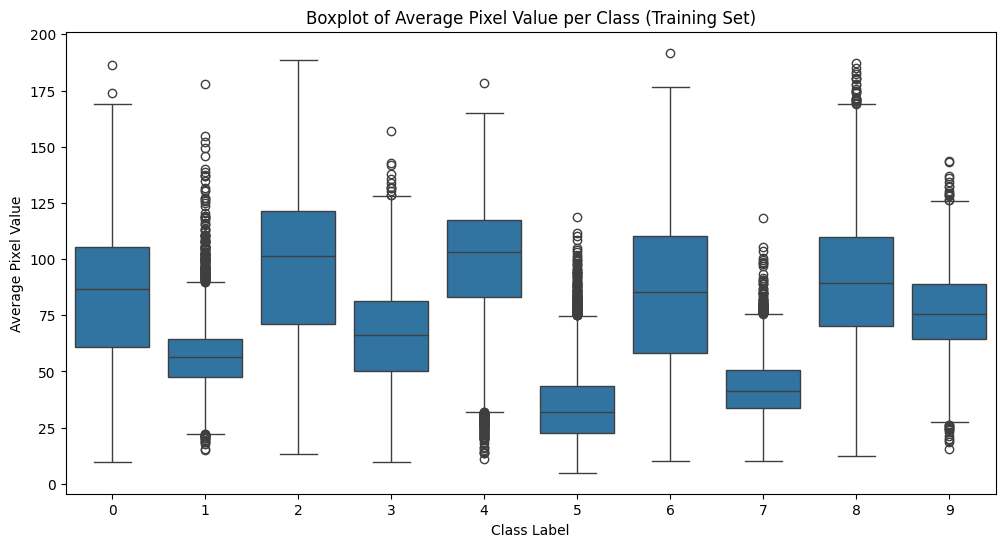

In [ ]:
# do a boxplot of each class average pixel value per class
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='average_pixel', data=df_train)
plt.title('Boxplot of Average Pixel Value per Class (Training Set)')
plt.xlabel('Class Label')
plt.ylabel('Average Pixel Value')
plt.show()


The boxplot shows a huge variability of the average pixel intensity across classes. Some classes, like 2 and 6, are higher in their median pixel value, while others, like 5 and 7, are lower in their median value, showing variation in brightness. The presence of all classes with outliers is the sign that there are some images with extremely different pixel intensities, and that could be due to variations in contrast or background. Classes 2, 6, and 8 possess a greater interquartile range, i.e., they contain a large spread of pixel values, whereas Class 7 contains the smallest range of pixel intensities, reflecting that it contains darker images. Such differences reflect the need for preprocessing techniques such as normalization or standardization in order to standardize pixel intensity variation across classes. Moreover, outlier detection would also mark noisy or wrongly labeled images, and histogram equalization would improve image contrast in the scenario of brightness variation degrading model performance.

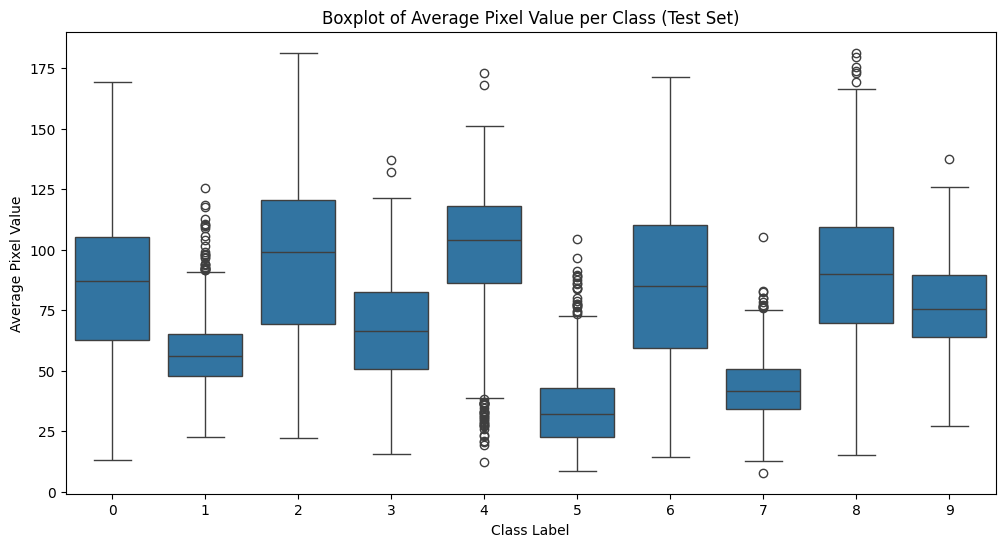

In [ ]:
# do a boxplot of each class average pixel value per class
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='average_pixel', data=df_test)
plt.title('Boxplot of Average Pixel Value per Class (Test Set)')
plt.xlabel('Class Label')
plt.ylabel('Average Pixel Value')
plt.show()


<ipython-input-10-a57ce9d2e7e1>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(class_data, hist=False, label=f'Class {class_label}')
<ipython-input-10-a57ce9d2e7e1>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(class_data, hist=False, label=f'Class {class_label}')
<ipython

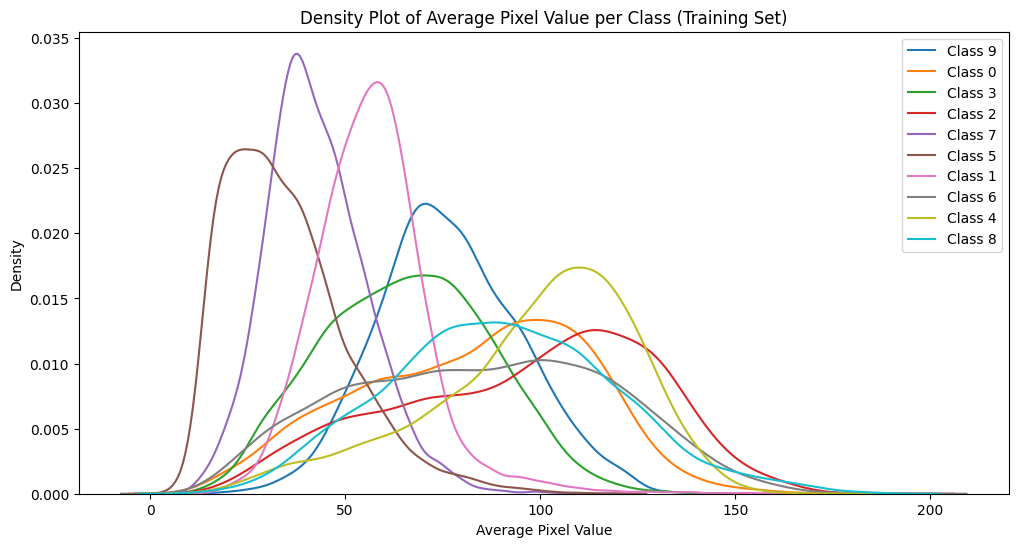

In [ ]:
# distributions of mean average pixel value per class
plt.figure(figsize=(12, 6))

for class_label in df_train['label'].unique():
    class_data = df_train[df_train['label'] == class_label]['average_pixel']
    sns.distplot(class_data, hist=False, label=f'Class {class_label}')

plt.title('Density Plot of Average Pixel Value per Class (Training Set)')
plt.xlabel('Average Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


This is a density plot of the average pixel value per class in the training data spread out. There is one distribution per class, each representing different pixel intensity features. Classes like Class 7 and Class 1 both peak towards lower average pixel values, which means that those images are darker. On the other hand, Classes 2, 4, and 6 are more dispersed with greater pixel values, indicating that they contain lighter images or areas with greater contrast. The overlapping density plots indicate that there are classes with similar distributions of pixel intensity, and others are more distant. These variations indicate the necessity for preprocessing measures such as normalization to prevent model performance from being hindered by variations in brightness. Aside from that, the skewness of the other distributions is a sign of the necessity to apply contrast stretching or histogram equalization for normalizing pixel intensity to some classes.

Class 9 outliers:


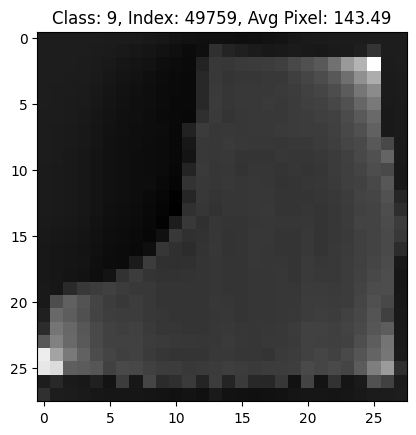

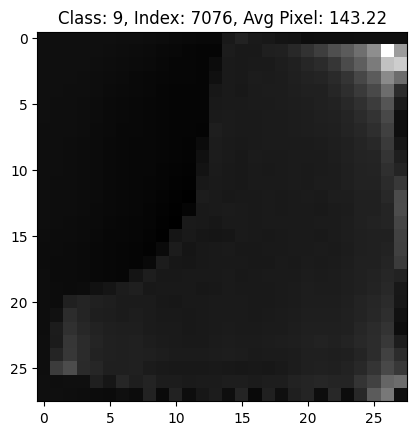

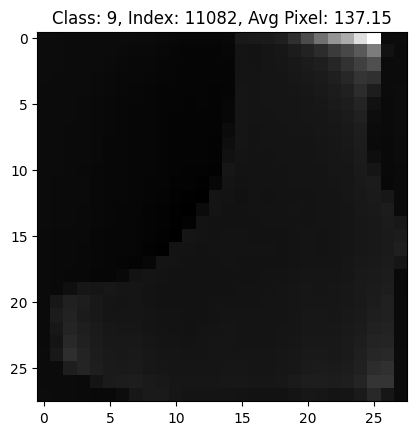

Class 0 outliers:


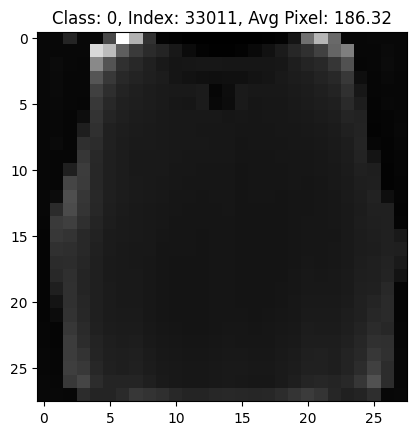

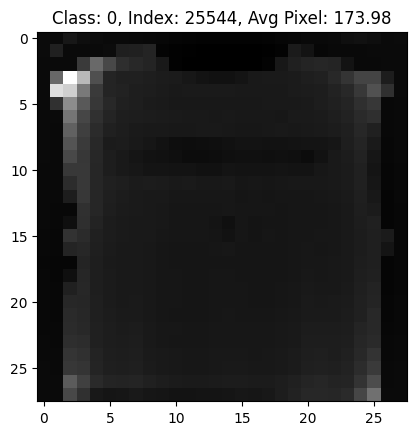

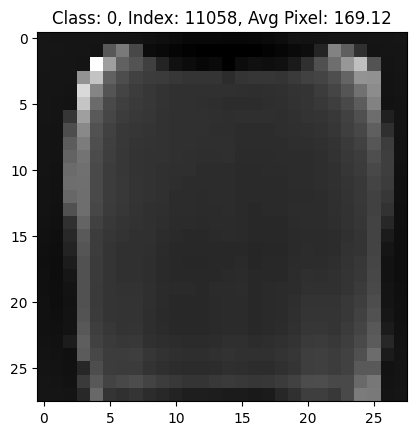

Class 3 outliers:


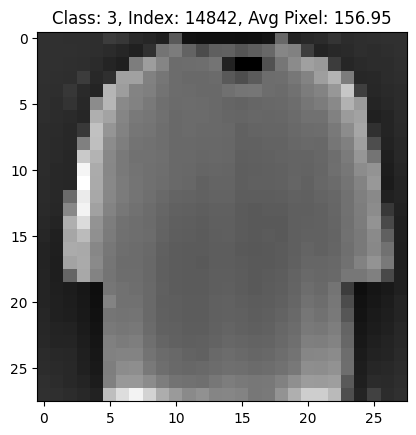

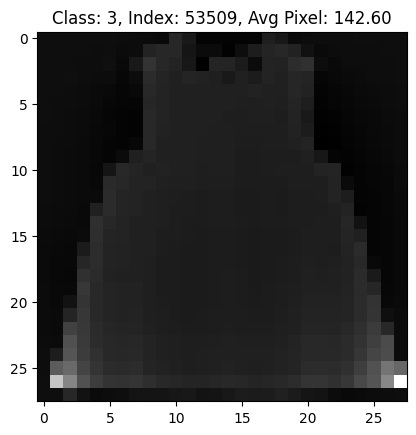

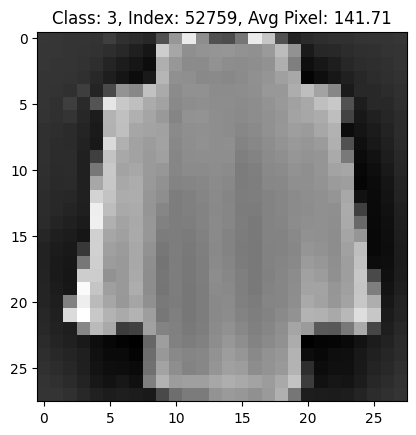

Class 2 outliers:


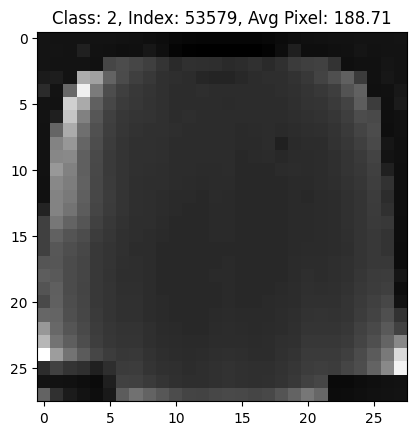

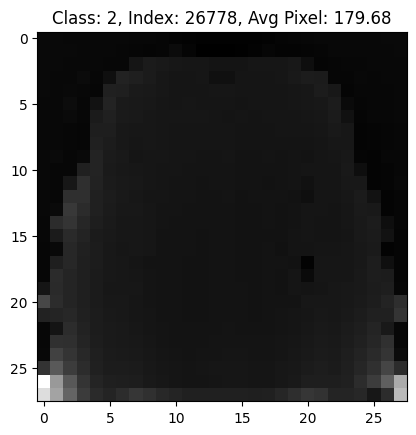

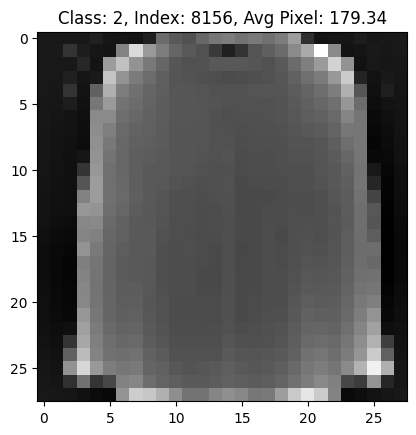

Class 7 outliers:


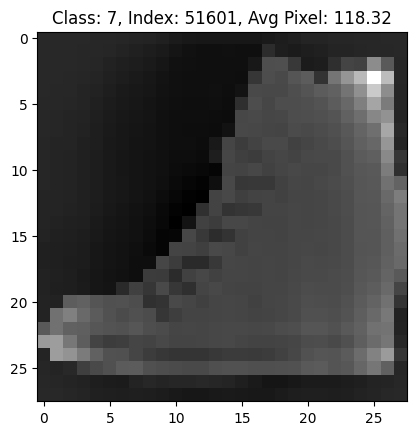

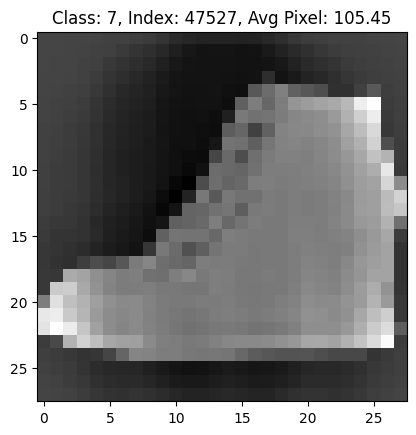

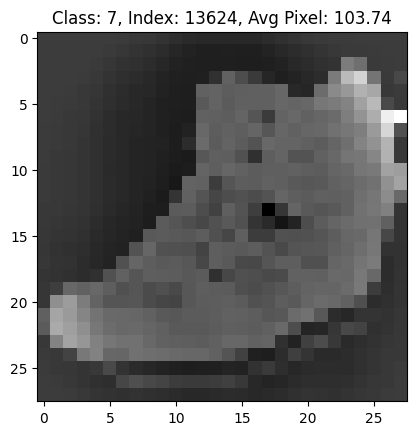

Class 5 outliers:


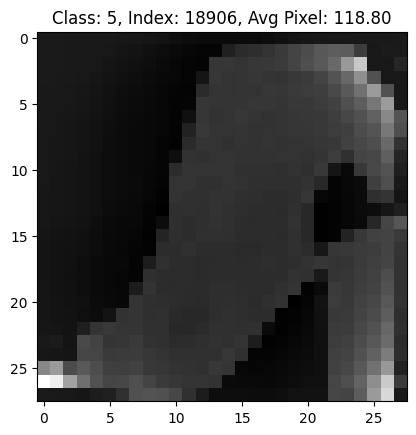

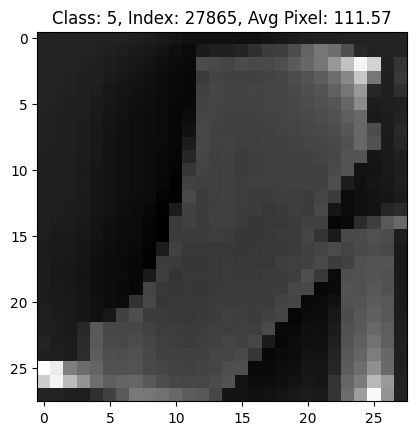

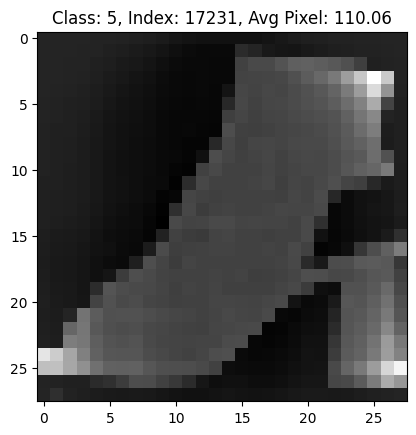

Class 1 outliers:


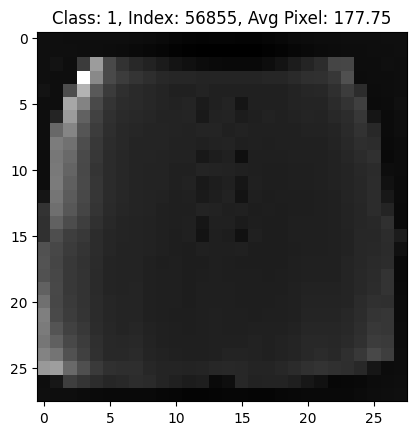

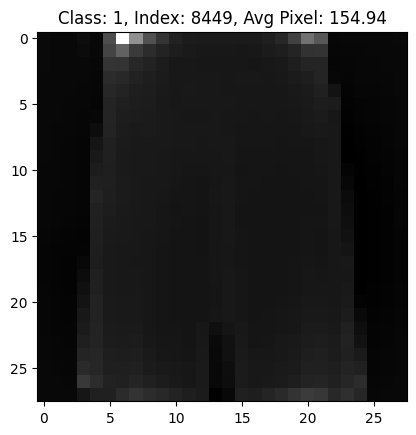

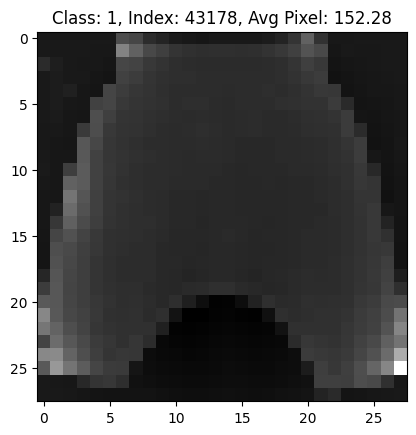

Class 6 outliers:


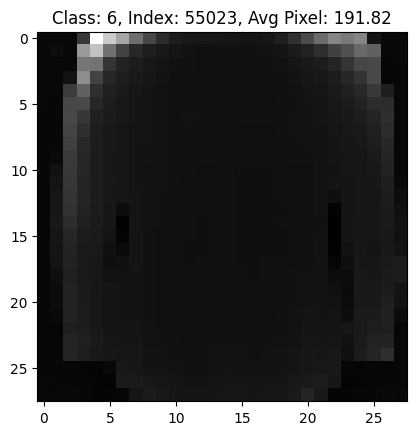

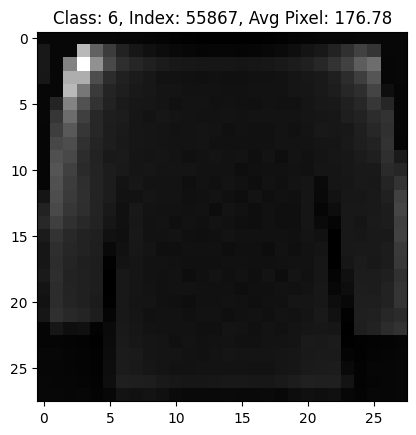

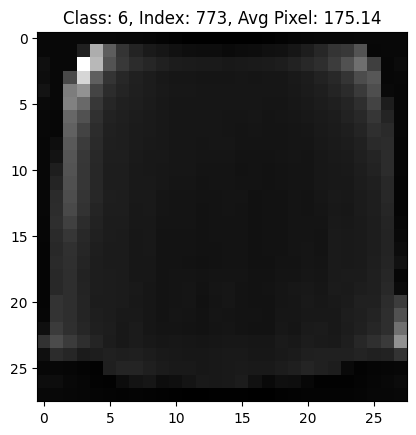

Class 4 outliers:


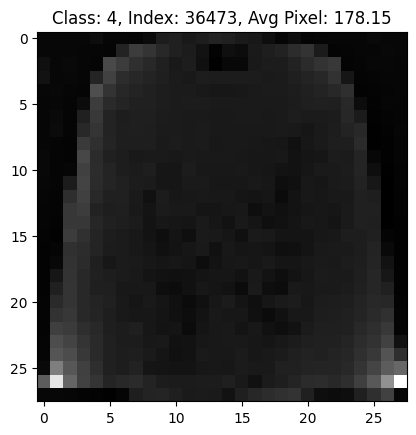

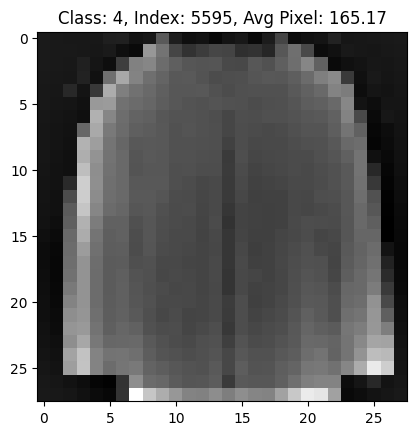

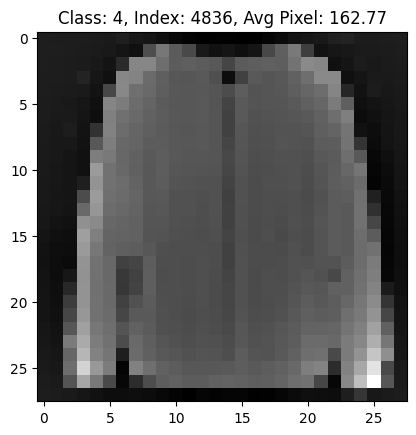

Class 8 outliers:


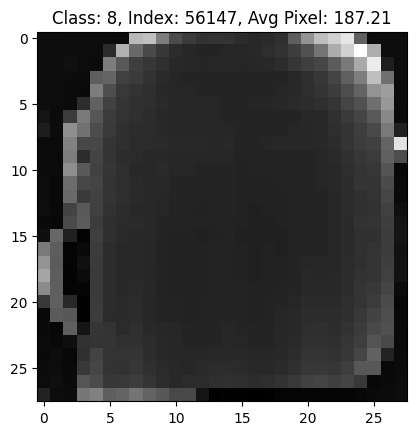

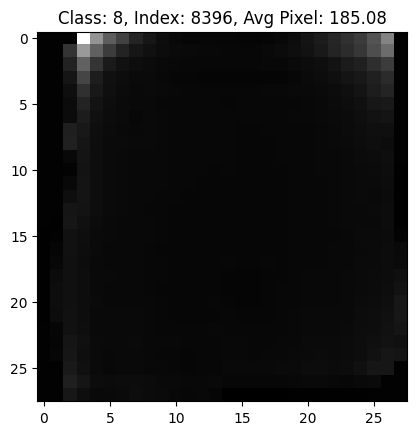

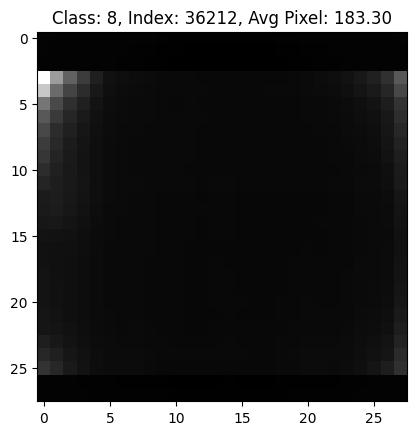

Class 9 outliers:


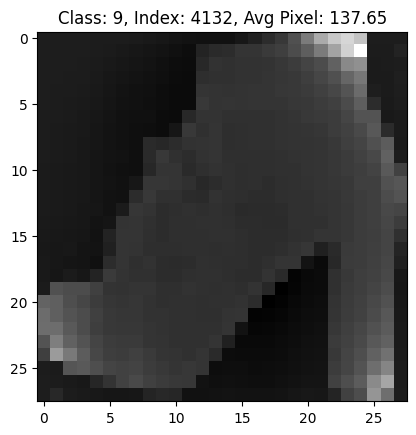

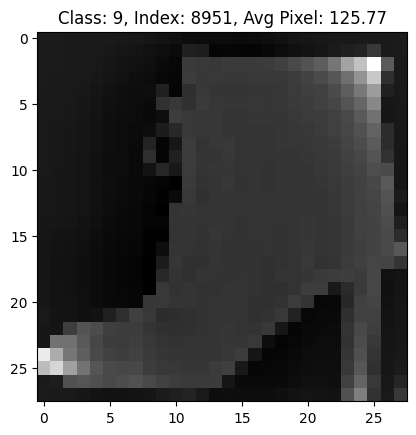

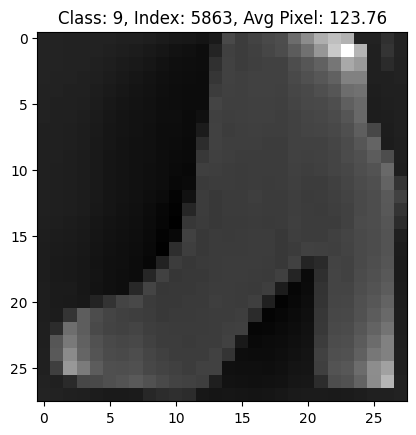

Class 2 outliers:


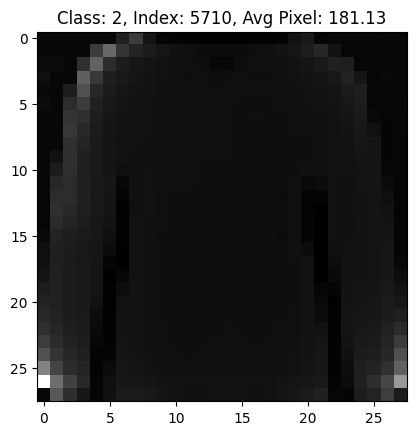

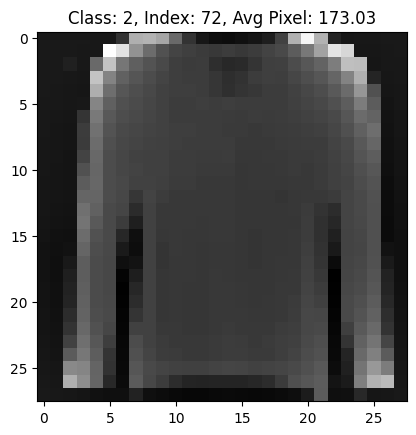

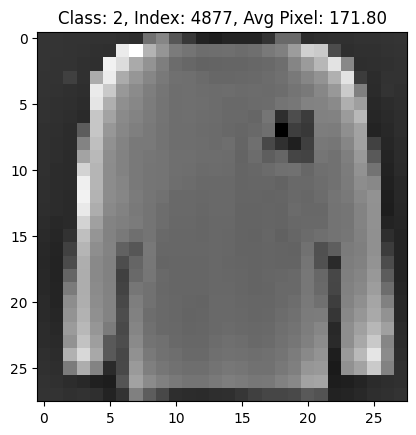

Class 1 outliers:


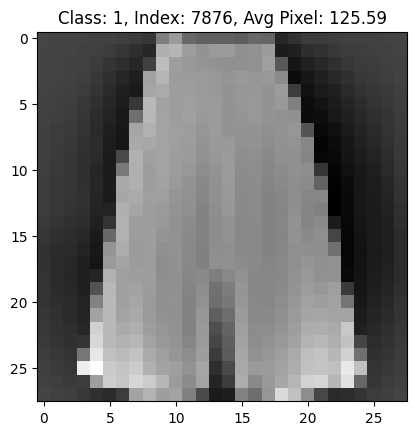

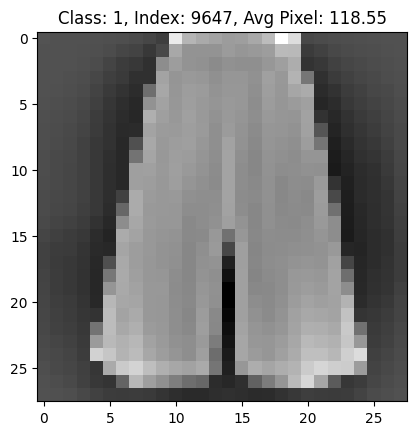

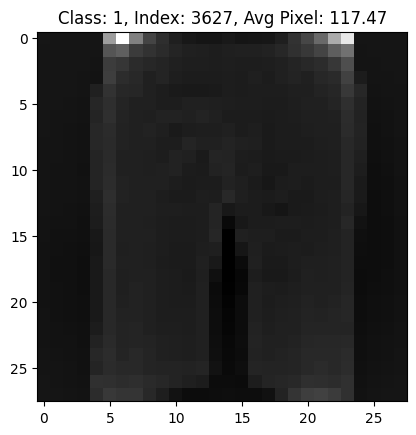

Class 6 outliers:


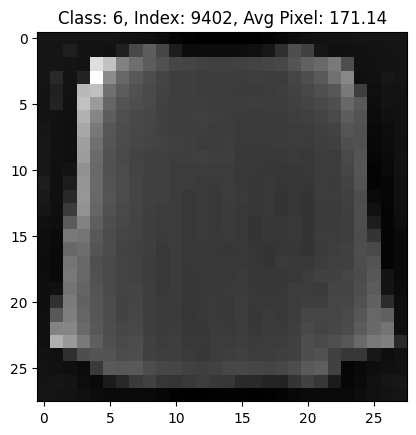

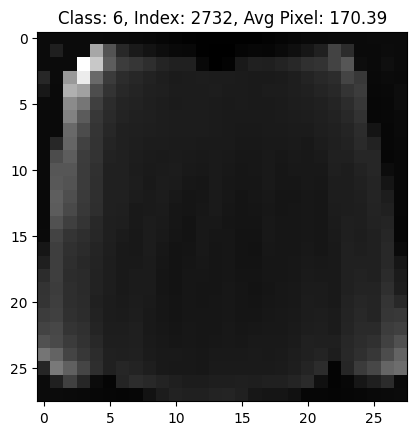

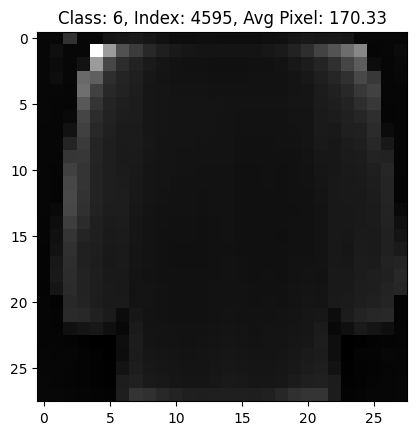

Class 4 outliers:


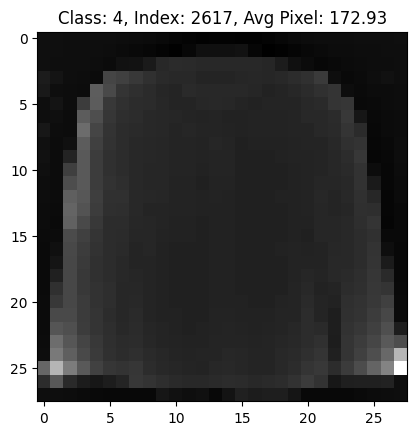

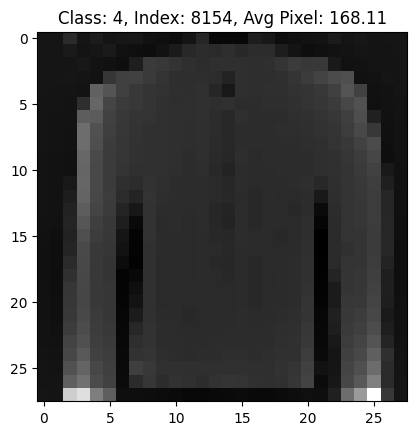

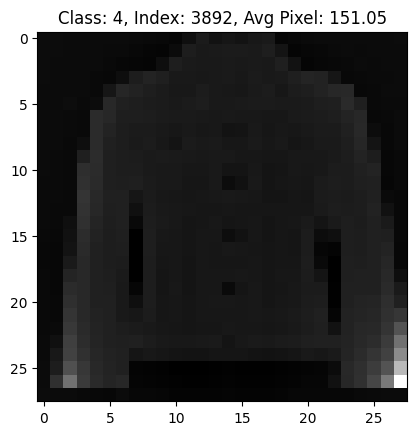

Class 5 outliers:


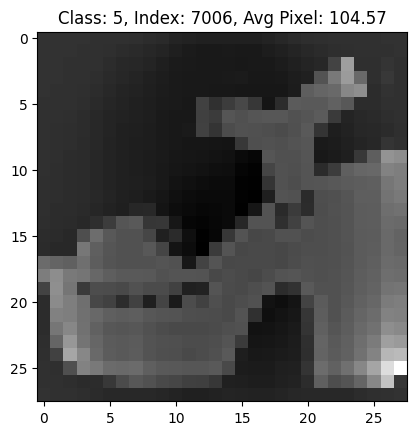

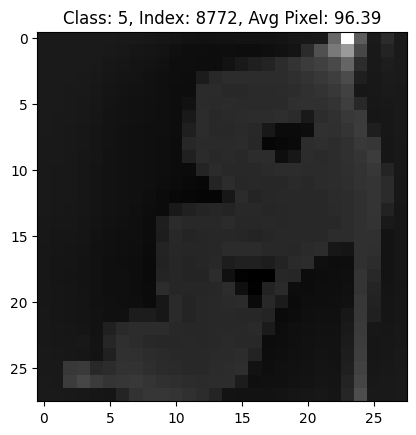

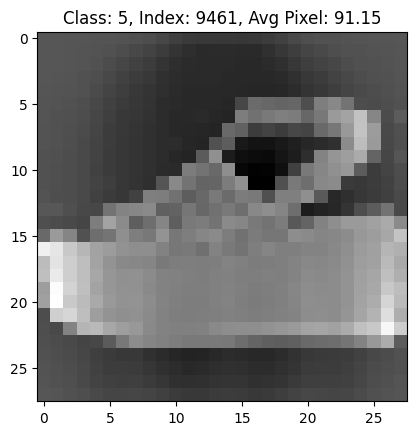

Class 7 outliers:


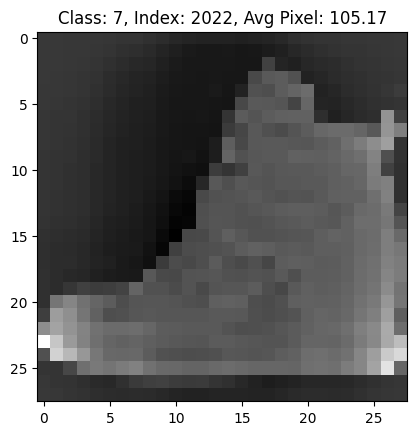

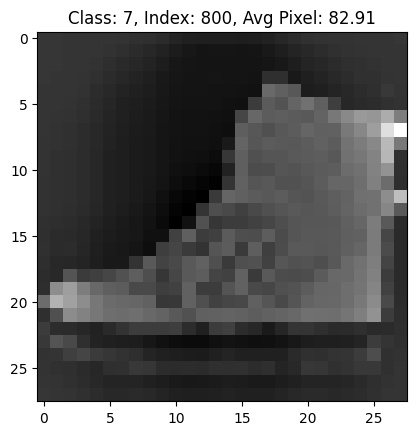

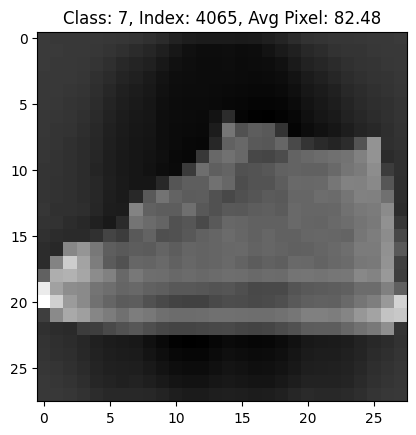

Class 3 outliers:


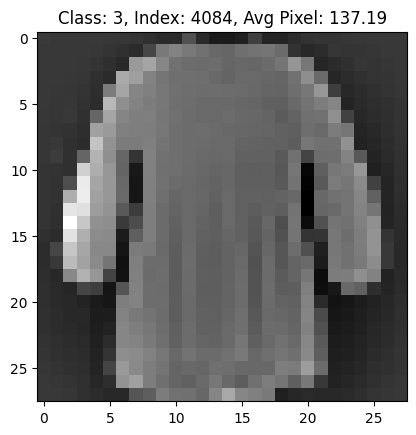

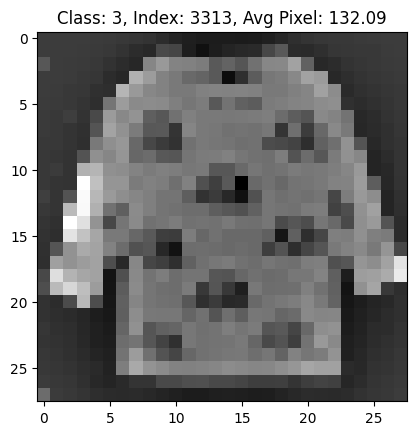

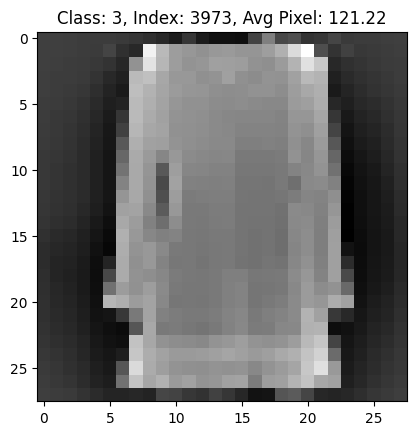

Class 8 outliers:


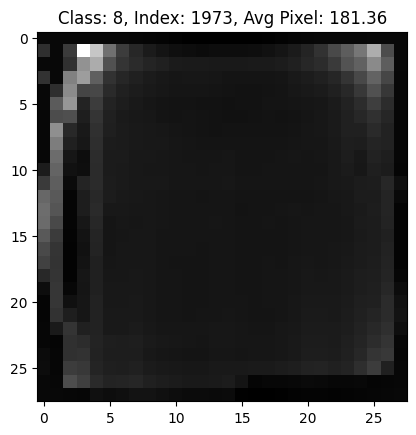

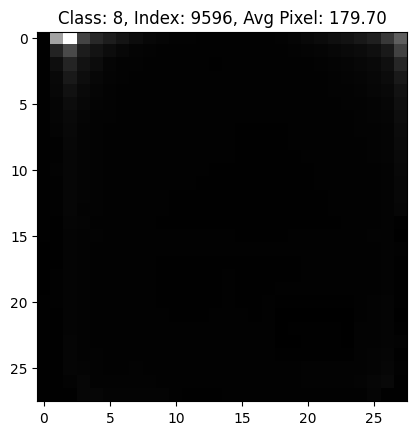

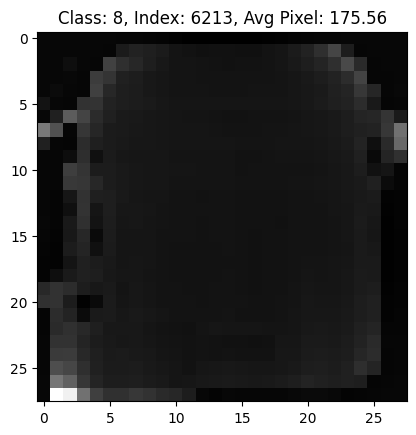

Class 0 outliers:


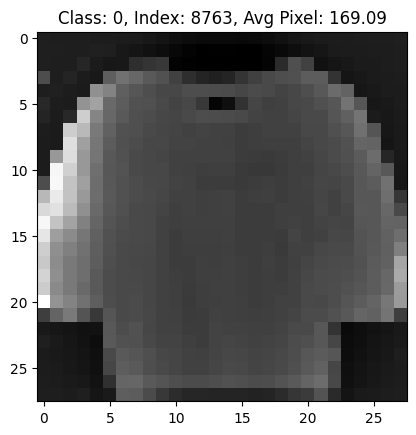

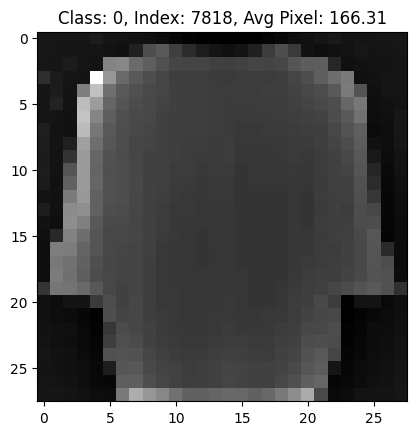

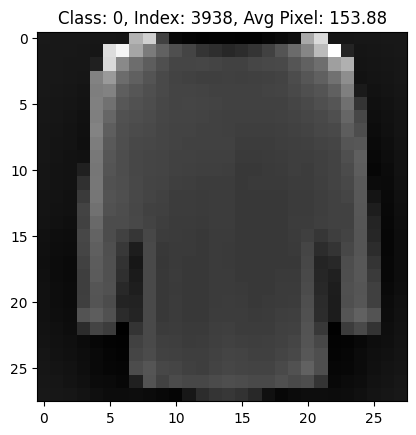

In [ ]:
import matplotlib.pyplot as plt

# Function to find and display outlier images
def show_outliers(df, x_data, label_col='label', pixel_col='average_pixel', num_outliers=3):
    for class_label in df[label_col].unique():
        class_df = df[df[label_col] == class_label]
        # Sort by average pixel value to find outliers (adjust for different outlier criteria)
        outliers = class_df.sort_values(pixel_col, ascending=False).head(num_outliers)

        print(f"Class {class_label} outliers:")
        for index in outliers.index:
            plt.imshow(x_data[index].reshape(28, 28), cmap='gray') # Reshape to 28x28
            plt.title(f"Class: {class_label}, Index: {index}, Avg Pixel: {outliers.loc[index, pixel_col]:.2f}")
            plt.show()

# Find and display outliers in training data
show_outliers(df_train, x_train)
# Find and display outliers in test data
show_outliers(df_test, x_test)

The images above are the outliers inside each class, representing mainly images that are low quality and difficult to identify even with the human eye what class is. Although removing them could be an intervention that can be suggested to the model, it reduces the efficiency of the model, since it reduces the variability of the images, and since as we can see in the boxplot of the test set it also has outliers, so removing this low-quality images it does not improve the model.

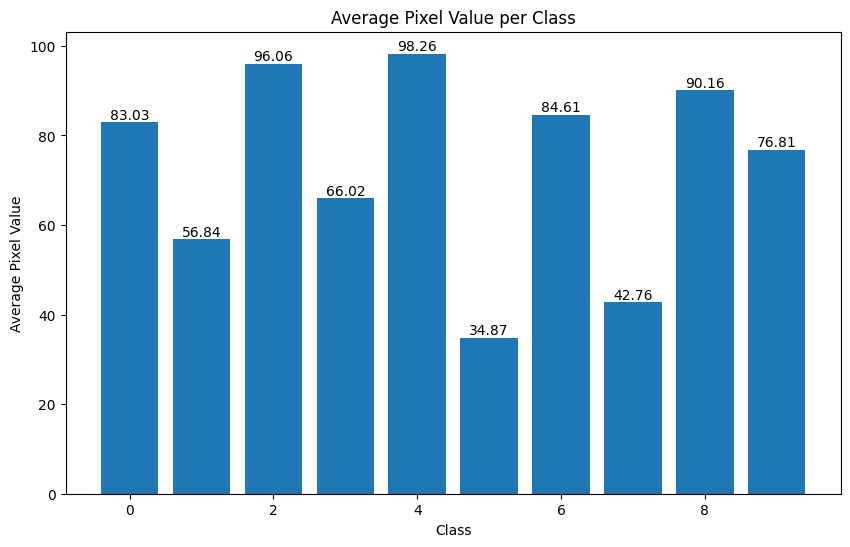

In [ ]:
# do a bar plot of each class average and include the values
# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_avg_pixel_per_class_train.index, mean_avg_pixel_per_class_train.values)
plt.title('Average Pixel Value per Class')
plt.xlabel('Class')
plt.ylabel('Average Pixel Value')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


In [ ]:
df_train.head(50)

label  average_pixel
0       9      97.253827
1       0     107.905612
2       0      36.558673
3       3      59.501276
4       0      78.044643
5       2     107.353316
6       7      41.487245
7       2     146.915816
8       5      25.372449
9       5      51.908163
10      0      88.727041
11      9     100.950255
12      5      38.174745
13      5      30.213010
14      7      25.408163
15      9      83.215561
16      1      66.477041
17      0      94.311224
18      6     112.251276
19      4      40.554847
20      3      83.436224
21      1      61.104592
22      4      75.631378
23      8      99.718112
24      4     114.661990
25      3      83.713010
26      0      94.362245
27      2     138.906888
28      4      76.145408
29      4     120.084184
30      5      16.295918
31      3      45.141582
32      6      99.042092
33      6      19.246173
34      0      27.590561
35      8      56.047194
36      5      55.525510
37      2      68.687500
38      1      64.011480
39      6     133.772959
40      6     107.327806
41      7      49.371173
42      9      82.479592
43      5      35.969388
44      9     126.221939
45      2      93.821429
46      7      43.753827
47      3      89.299745
48      0      88.188776
49      3      98.229592

In [ ]:
# Check the data types and shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("x_train data type:", x_train.dtype)
print("y_train data type:", y_train.dtype)
print("x_test data type:", x_test.dtype)
print("y_test data type:", y_test.dtype)


# Print some data examples
print("\nFirst 5 labels in y_train:", y_train[:5])
print("\nShape of first image in x_train:",x_train[0].shape)

# Examine the first image
first_image = x_train[0]
print("\nFirst image data (first 10 elements):", first_image.flatten()[:10])

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
x_train data type: uint8
y_train data type: uint8
x_test data type: uint8
y_test data type: uint8

First 5 labels in y_train: [9 0 0 3 0]

Shape of first image in x_train: (28, 28)

First image data (first 10 elements): [0 0 0 0 0 0 0 0 0 0]


# Normalization and Flatening

In [ ]:
# Normalize and Flatten
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

We normalized and flattened the data in order to make sure the SVM model could understand how to operate the data, in order for the machine learning model to properly function, the imput must be converted from 2D to 1D vectords.

# PCA

In [ ]:
# Reduction of dimensionality with PCA
pca = PCA(n_components=10)
x_train_pca0 = pca.fit_transform(x_train)
x_test_pca0 = pca.transform(x_test)

In [ ]:
# grab a sample so the gridsearch doesn't take so long
x_train_pca_small = x_train_pca0[:5000]
y_train_small = y_train[:5000]

# check the distribution of each class
unique, counts = np.unique(y_train_small, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 457]
 [  1 556]
 [  2 504]
 [  3 501]
 [  4 488]
 [  5 493]
 [  6 493]
 [  7 512]
 [  8 490]
 [  9 506]]


In [ ]:
# grab another sample but equally distributed
df_train["label"] = y_train  # Add labels column

# Sample 500 images per class and combine into a new DataFrame
df_sampled = df_train.groupby("label").apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

# Check class distribution to confirm we have 500 per class
print(df_sampled["label"].value_counts())

# Display the first few rows of the new DataFrame
print(df_sampled.head())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: count, dtype: int64
   label  average_pixel
0      0      40.584184
1      0      46.366071
2      0     109.338010
3      0      33.464286
4      0      39.103316


<ipython-input-19-e53dcc20cb36>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_train.groupby("label").apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)


With PCA we reduced variability in the data for better computational power, and highlighting trends in and patterns in the data, that could've previously gone unnoticed.

# Baseline Model

In [ ]:
# Training of SVM with kernel RBF
svm_model0 = SVC(kernel='rbf', C=1, gamma='auto')
svm_model0.fit(x_train_pca0, y_train)

SVC(C=1, gamma='auto')

For the baseline model we just use the pca data with 100 components without checking the hyperparameters x_train_pca0 data with svm model

In [ ]:
# Model evaluation
y_pred = svm_model0.predict(x_test_pca0)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7775
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1000
           1       0.99      0.92      0.95      1000
           2       0.73      0.66      0.69      1000
           3       0.82      0.82      0.82      1000
           4       0.71      0.65      0.68      1000
           5       0.94      0.81      0.87      1000
           6       0.59      0.52      0.55      1000
           7       0.89      0.89      0.89      1000
           8       0.57      0.98      0.72      1000
           9       0.89      0.83      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



The model achieved 77.75% accuracy overall, with notable variations across classes. Class 1 showed high performance, while classes 6 and 8 had lower recall scores. The macro and weighted averages are around 78%, indicating a balanced, but improvable, performance. Further model adjustments may be needed.

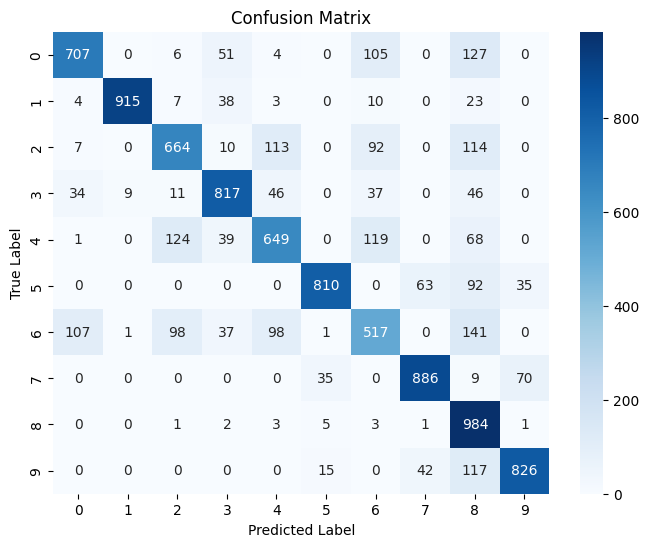

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

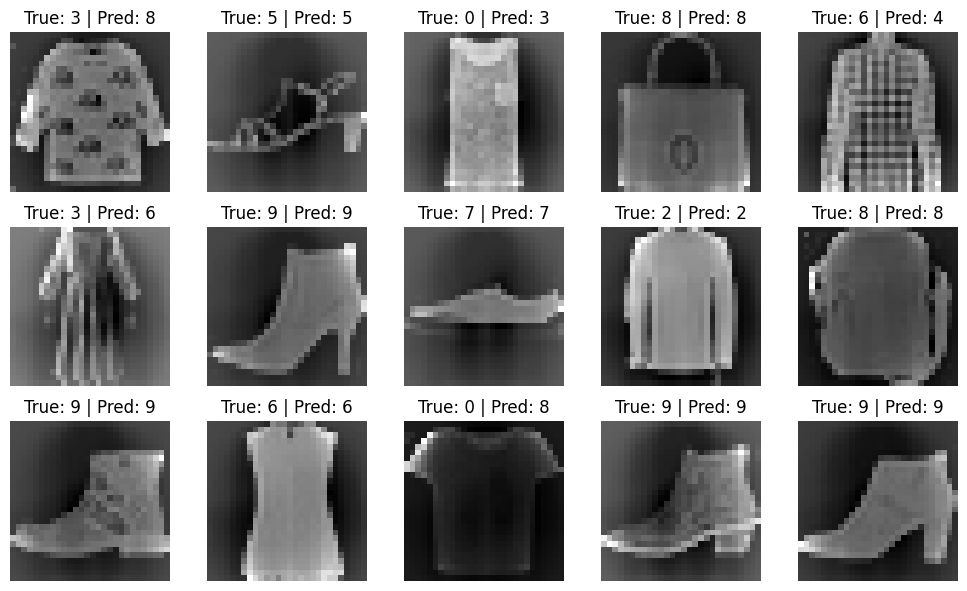

In [ ]:
# Predictions images with the true values
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
indices = np.random.choice(len(x_test), 15, replace=False)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = x_test[idx].reshape(28, 28)  # Restore
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {y_test[idx]} | Pred: {y_pred[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

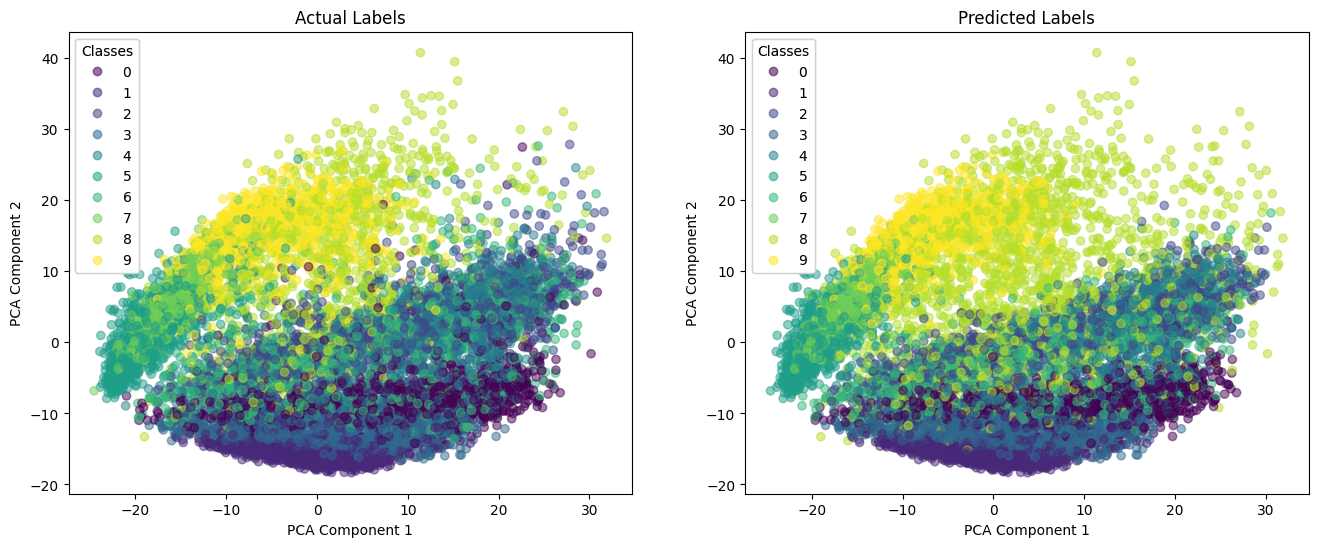

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Actual labels
scatter = ax[0].scatter(x_test_pca0[:, 0], x_test_pca0[:, 1], c=y_test, cmap='viridis', alpha=0.5)
ax[0].set_title('Actual Labels')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].add_artist(legend1)

# Predicted labels
scatter = ax[1].scatter(x_test_pca0[:, 0], x_test_pca0[:, 1], c=y_pred, cmap='viridis', alpha=0.5)
ax[1].set_title('Predicted Labels')
ax[1].set_xlabel('PCA Component 1')
ax[1].set_ylabel('PCA Component 2')
legend2 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].add_artist(legend2)

plt.show()

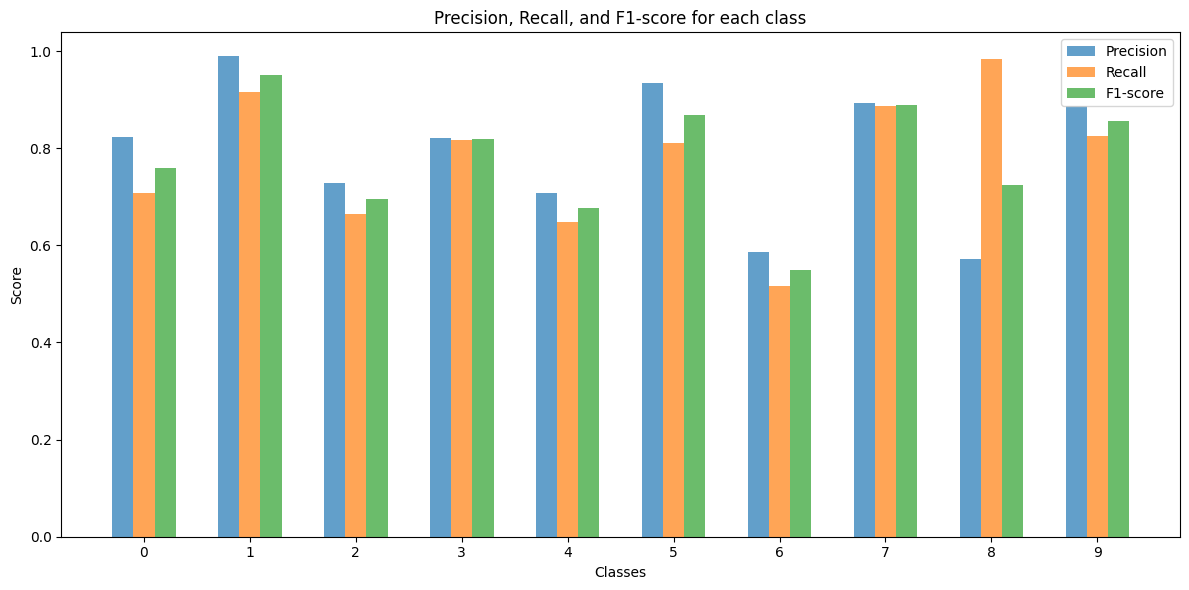

In [ ]:
# Bar plot visualization of each class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
labels = np.arange(10) # Change to numerical for better control

width = 0.2  # Set width of the bars

plt.figure(figsize=(12, 6)) # Adjusted figure size for better visualization

# Plotting each group of bars for precision, recall, and F1-score for each class
plt.bar(labels - width, precision, width, label='Precision', alpha=0.7)
plt.bar(labels, recall, width, label='Recall', alpha=0.7)
plt.bar(labels + width, f1, width, label='F1-score', alpha=0.7)

plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(labels, labels) # Ensure x-ticks align with the labels
plt.legend()
plt.title("Precision, Recall, and F1-score for each class")
plt.tight_layout()
plt.show()

As a baseline model for image recognition using SVM is not a bad model at all, but it is just a baseline, there is a lot of room of improvement for the hyperparameters, etc..

# Hyperparameter tuning

In [ ]:
# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_pca_small, y_train_small)
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 10, 'gamma': 'scale'}


In [ ]:
# Reduction of dimensionality with PCA
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

This code performs hyperparameter tuning for the SVM model using GridSearchCV. It defines a param_grid for C and gamma, then searches for the best combination using 3-fold cross-validation and accuracy as the scoring metric. Finally, it prints the optimal hyperparameters. The best parameters for our dataset is C of 10 and gamma of scale

# First Model

In [ ]:
# Training of SVM with kernel RBF
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(x_train_pca, y_train)

SVC(C=10)

For the first model we are going to use the hyperparameters with x_train_pca data with svm model

In [ ]:
# Model evaluation
y_pred = svm_model.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8922
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.81      0.83      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.69      0.72      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



The model achieved an overall accuracy of 89.22%. Precision, recall, and F1-scores were high for most classes, particularly 1, 5, 7, 8, and 9. Class 6 had the lowest scores, indicating it was the most challenging to classify, this class stands for shirts, what could be reasonable since it can be confused easily with other categories, such as t-shirts. The macro and weighted averages also reflect the overall good performance of the model across all classes, though some classes had better metrics than others.

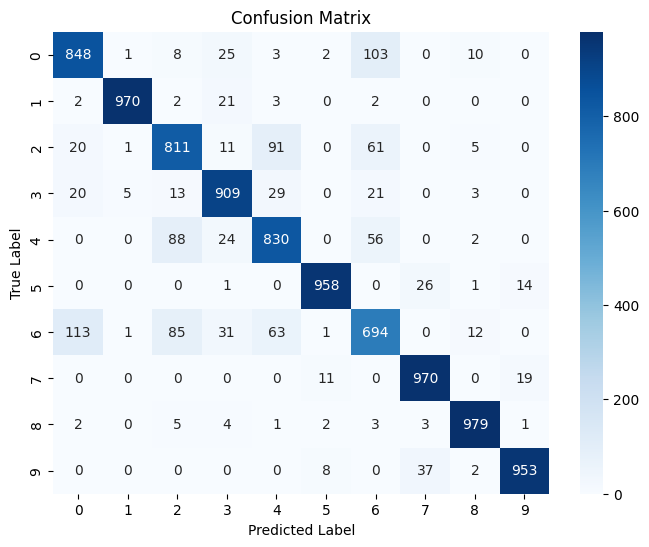

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows a strong model performance, with most predictions on the diagonal, indicating correct classifications. Misclassifications occur, notably class 6 confused with 0. Some errors exist in classes 2, 4, and 9. Overall, the model performs well but could improve in reducing specific misclassification patterns.

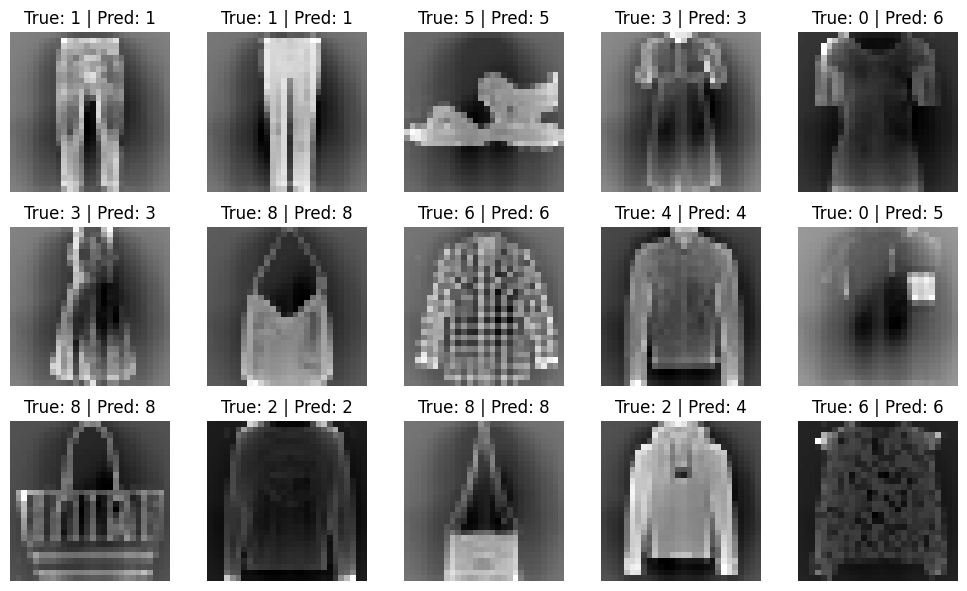

In [ ]:
# Predictions images with the true values
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
indices = np.random.choice(len(x_test), 15, replace=False)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = x_test[idx].reshape(28, 28)  # Restore
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {y_test[idx]} | Pred: {y_pred[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The model mostly classifies correctly, but some errors occur, notably confusing T-shirts with shirts and pullovers with coats. This misclassifications suggest challenges in distinguishing similar categories, indicating potential areas for improvement.

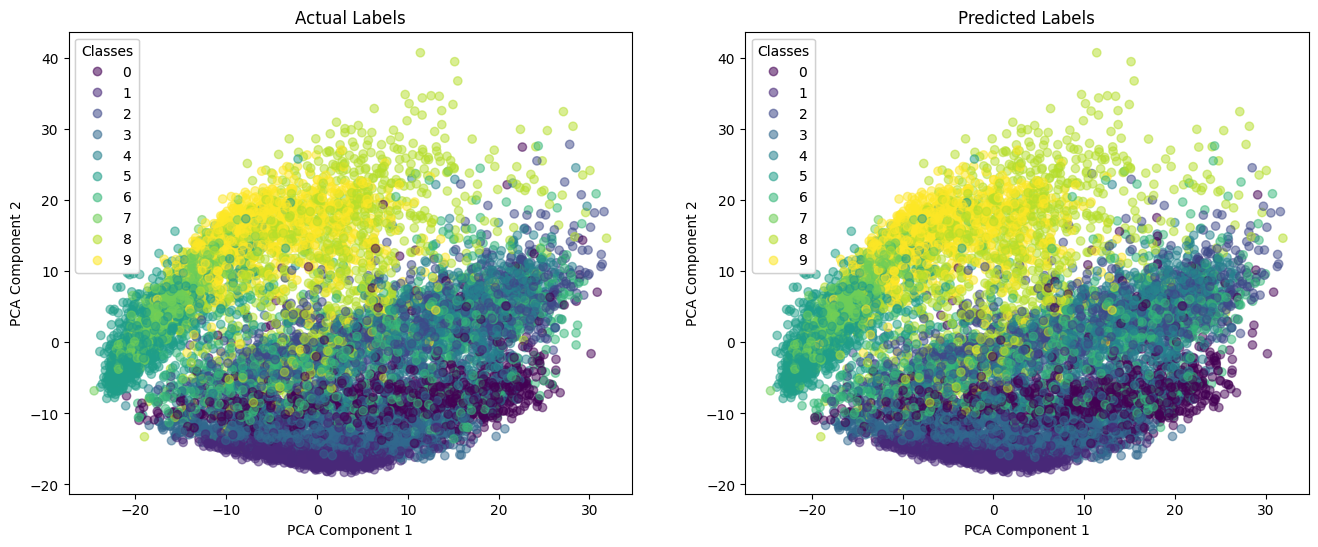

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Actual labels
scatter = ax[0].scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.5)
ax[0].set_title('Actual Labels')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].add_artist(legend1)

# Predicted labels
scatter = ax[1].scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.5)
ax[1].set_title('Predicted Labels')
ax[1].set_xlabel('PCA Component 1')
ax[1].set_ylabel('PCA Component 2')
legend2 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].add_artist(legend2)

plt.show()

The PCA visualization compares actual vs. predicted labels, showing clustering patterns. The predicted distribution closely matches the actual, indicating good model performance. Some class overlaps suggest misclassifications in ambiguous regions. Refining decision boundaries or improving feature extraction could enhance accuracy. Overall, the model captures the data structure well.

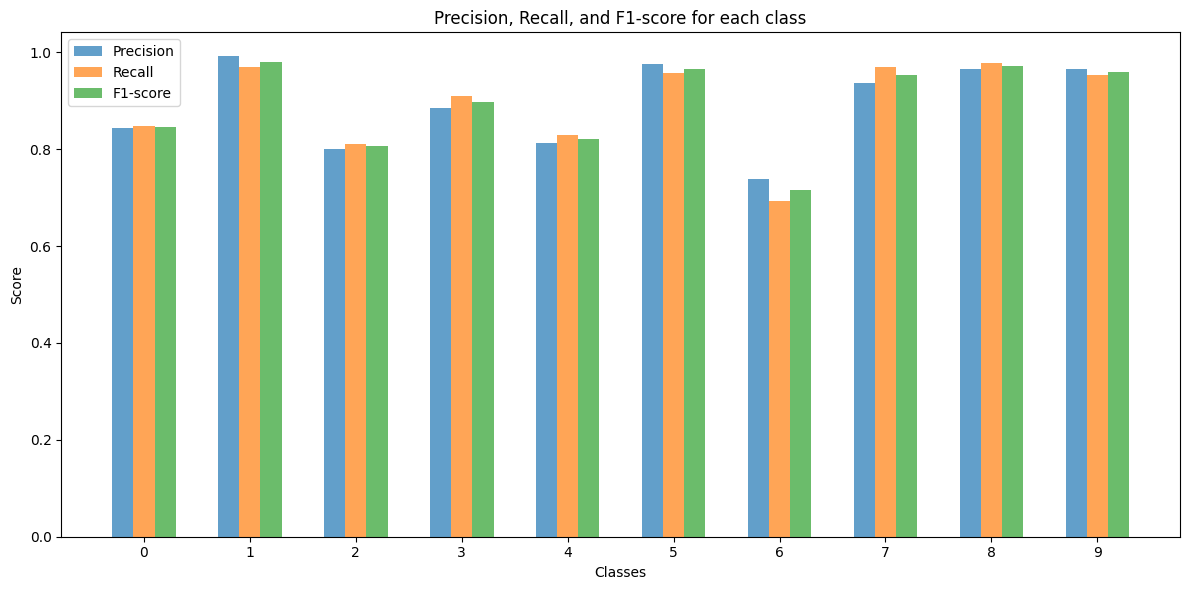

In [ ]:
# Bar plot visualization of each class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
labels = np.arange(10) # Change to numerical for better control

width = 0.2  # Set width of the bars

plt.figure(figsize=(12, 6)) # Adjusted figure size for better visualization

# Plotting each group of bars for precision, recall, and F1-score for each class
plt.bar(labels - width, precision, width, label='Precision', alpha=0.7)
plt.bar(labels, recall, width, label='Recall', alpha=0.7)
plt.bar(labels + width, f1, width, label='F1-score', alpha=0.7)

plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(labels, labels) # Ensure x-ticks align with the labels
plt.legend()
plt.title("Precision, Recall, and F1-score for each class")
plt.tight_layout()
plt.show()

Also, in this visualisations we can see the different bar plot metrics for each class classification and their metrics, here we can see also the classes that are mainly missclassified and which ones are showing a better performance overall.

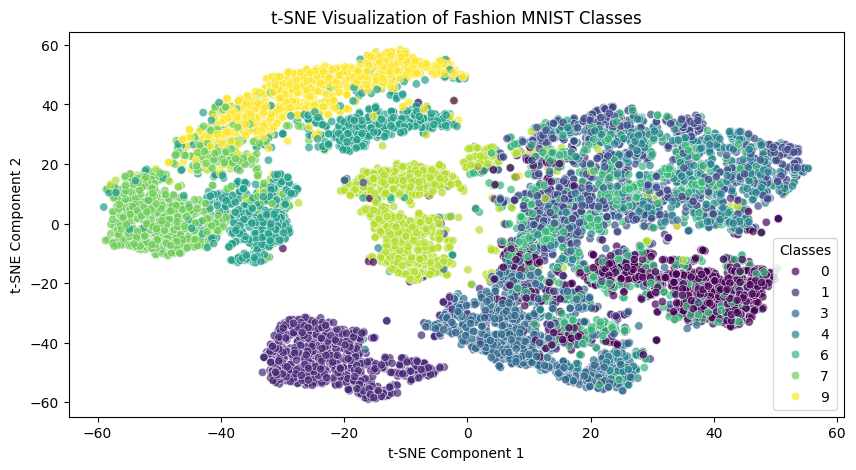

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=42)
x_test_tsne = tsne.fit_transform(x_test_pca)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_test_tsne[:,0], y=x_test_tsne[:,1], hue=y_test, palette='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Fashion MNIST Classes")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")
plt.show()

In [ ]:
!pip install umap-learn
import umap
import seaborn as sns
reducer = umap.UMAP(n_components=2, random_state=42)
x_test_umap = reducer.fit_transform(x_test_pca)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_test_umap[:,0], y=x_test_umap[:,1], hue=y_test, palette='viridis', alpha=0.7)
plt.title("UMAP Visualization of Fashion MNIST Classes")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Classes")
plt.show()

Overall the first model is a good model as a starting point for a classification task for images such as this ones, as we can see in the metrics there is a tendency to missclassify t-shirts with shirts, what it is going to be a challenge to adress.

# Feature engeeinering with histograms of Oriented Gradients

To solve the issue of missclasification we are going to implement HOG (Histogram of Oriented Gradients) to capture shape and texture, what is crucial for distinguishing clothing items in Fashion MNIST dataset. This could improve model accuracy by providing richer feature representations.

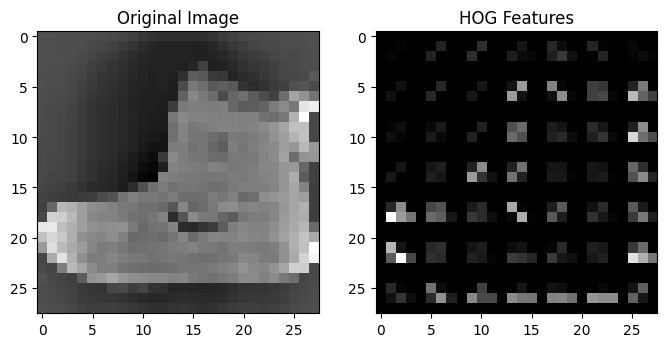

In [ ]:
from skimage.feature import hog

# Extract HOG features for one image
sample_image = x_train[0].reshape(28, 28)  # Select a sample T-shirt image and reshape it
hog_features, hog_image = hog(sample_image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)

# Plot original vs. HOG
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(sample_image, cmap="gray")
ax[0].set_title("Original Image")

ax[1].imshow(hog_image, cmap="gray")
ax[1].set_title("HOG Features")

plt.show()


The image contrasts a grayscale boot image with its HOG feature representation. The HOG image reveals gradient orientations within cells, highlighting the boot's shape and texture. This transformation makes the image more suitable for feature-based machine learning tasks.

In [ ]:
# generate a new column of hog function of each image
from skimage.feature import hog

# add HOG features as a new column to your DataFrame with a function
def extract_hog_features(image):
  """Extracts HOG features from an image."""
  features, _ = hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
  return features

# Example usage:
# Create a new column in df_train to store the HOG features
df_train['hog_features'] = [extract_hog_features(image.reshape(28, 28)) for image in x_train]

print(df_train.head())


   label  average_pixel                                       hog_features
0      9      97.253827  [0.05623241744453445, 0.21901896562720735, 0.0...
1      0     107.905612  [0.007061486021517142, 0.031926005885629674, 0...
2      0      36.558673  [0.05769323648735211, 0.22470869212779815, 0.0...
3      3      59.501276  [0.013179898966325322, 0.05133422978876825, 0....
4      0      78.044643  [0.03102780665142991, 0.12084983053023046, 0.0...


here just we add the values to the original dataset defining a function to extract hog features for each image

In [ ]:
# Function to calculate average HOG features per image
def average_hog_features(hog_features_list):
    return np.mean(hog_features_list, axis=0)

# Apply the average HOG function to the dataframe
df_train['avg_hog_features'] = df_train['hog_features'].apply(average_hog_features)

# Group data by class and calculate the mean of the average HOG features
average_hog_per_class = df_train.groupby('label')['avg_hog_features'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()

print("Average HOG features per class:\n", average_hog_per_class)


Average HOG features per class:
    label  avg_hog_features
0      0          0.107191
1      1          0.091262
2      2          0.105136
3      3          0.099545
4      4          0.106768
5      5          0.106720
6      6          0.110551
7      7          0.107079
8      8          0.108065
9      9          0.105163


This code calculates average HOG features per image and then per class, providing a summarized representation of texture and shape characteristics for each category. This can help in image classification tasks by highlighting distinctive features. Class 6 (shirts) has the highest average HOG value, while class 1 (trousers) has the lowest, indicating different gradient characteristics that can help to classification tasks.

In [ ]:
# Reduction of dimensionality with PCA
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

here we just do pca again to computionally eficiency and reduce dimensionality

In [ ]:
#Extract HOG features for the test set
hog_features_test = [extract_hog_features(image.reshape(28, 28)) for image in x_test]
hog_features_test_array = np.array(hog_features_test) #convert to numpy array
hog_features_train_array = np.array(df_train['hog_features'].tolist()) #convert to numpy array, grab the hog features from the df
pca_hog = PCA(n_components=100)
hog_features_pca = pca_hog.fit_transform(hog_features_train_array) # fit and transform training data
hog_test_pca = pca_hog.transform(hog_features_test_array) #transform test data using fitted pca

Class 6 (shirts) has the highest average HOG value, while class 1 (trousers) has the lowest, indicating different gradient characteristics.

# Second Model

In [ ]:
# Training of SVM with kernel RBF using best parameters from grid search
y_sampled = df_sampled['label'].to_numpy()
svm_model_best = SVC(kernel='rbf', **best_params)
svm_model_best.fit(hog_features_pca, y_train)

SVC(C=10)

For the second model we are using still the same parameters that we got from the hyperparameter tuning, but this time we are doing a model just with the hog features pca

In [ ]:
# Model evaluation
y_pred2 = svm_model_best.predict(hog_test_pca)
accuracy2 = accuracy_score(y_test, y_pred2) #corrected the y_pred here.
print(f'Accuracy: {accuracy2:.4f}')
print(classification_report(y_test, y_pred2))

Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.98      0.97      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.91      0.90      0.90      1000
           4       0.82      0.82      0.82      1000
           5       0.97      0.96      0.97      1000
           6       0.72      0.71      0.72      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



The model achieved 89.56% accuracy, which is a slightly improvement from the first one. Precision, recall, and F1-scores are high for most classes, especially 1, 5, 7, 8 and 9. Again, class 6 (shirts) has the lowest scores, indicating it's the hardest to classify still. The macro and weighted averages are also good, showing a balanced performance.

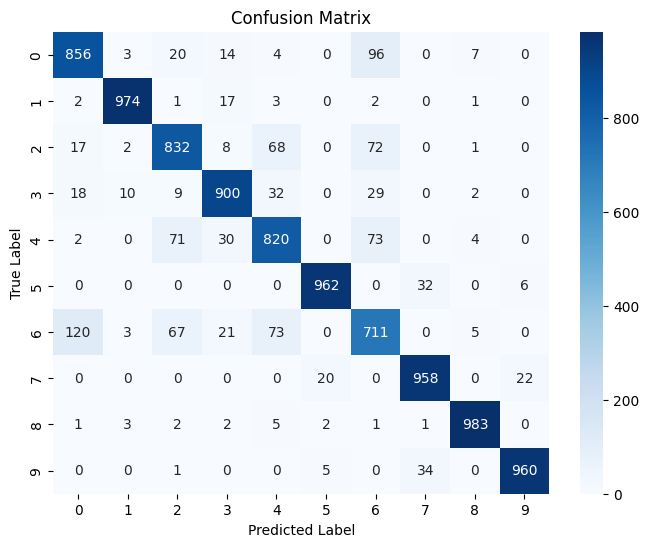

In [ ]:
# Confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Still is confusing the shirts and t-shirts in the model like in the last model.

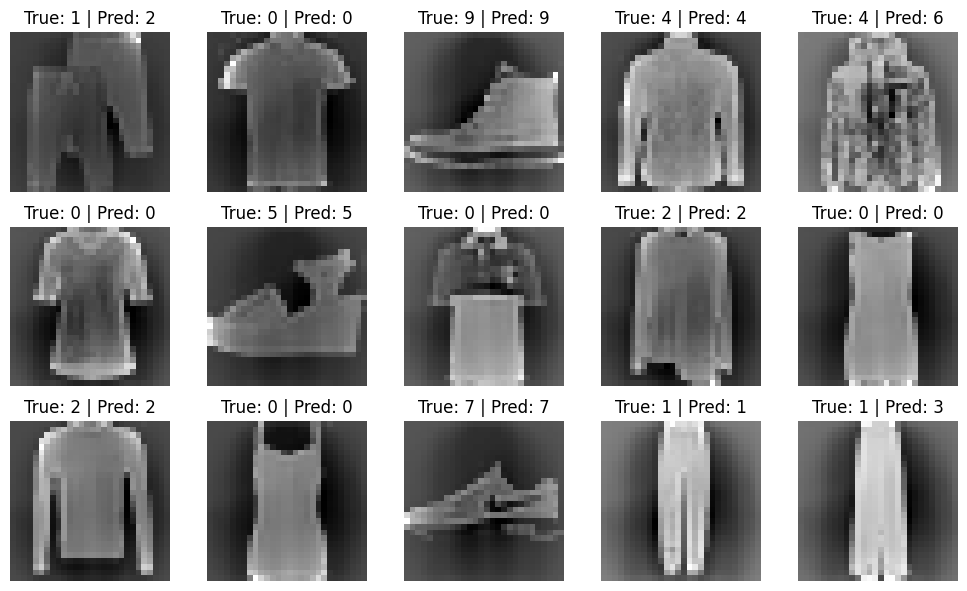

In [ ]:
# Predictions images with the true values
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
indices = np.random.choice(len(x_test), 15, replace=False)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = x_test[idx].reshape(28, 28)  # Restore
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {y_test[idx]} | Pred: {y_pred2[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The model mostly classifies correctly, but some errors occur indicating potential areas for improvement.

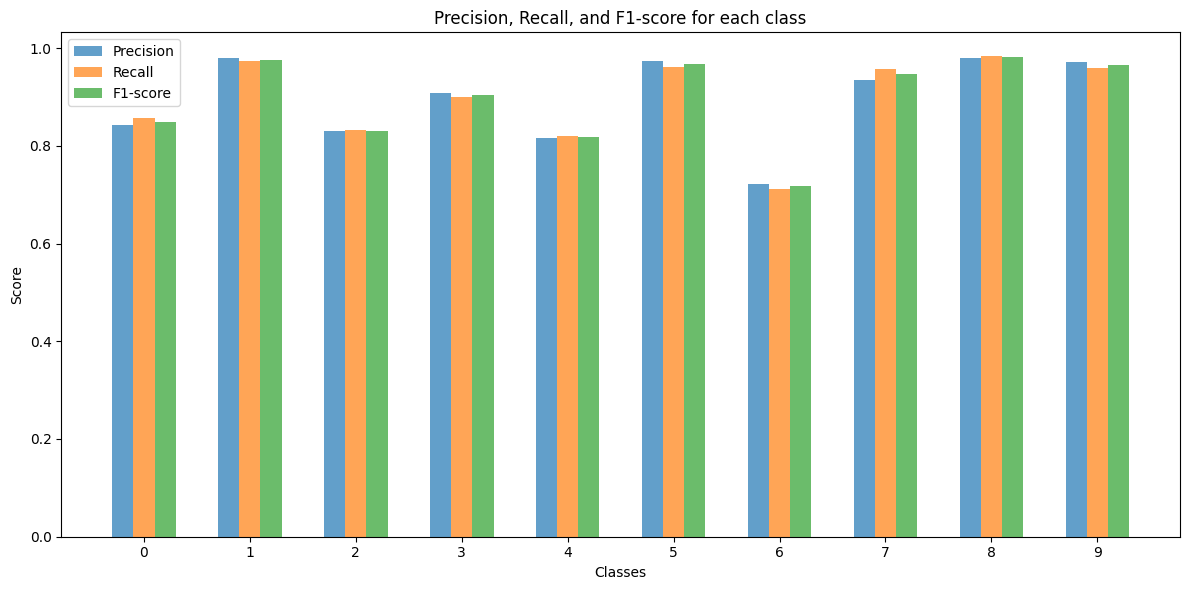

In [ ]:
# Bar plot visualization of each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred2, average=None)
labels = np.arange(10) # Change to numerical for better control

width = 0.2  # Set width of the bars

plt.figure(figsize=(12, 6)) # Adjusted figure size for better visualization

# Plotting each group of bars for precision, recall, and F1-score for each class
plt.bar(labels - width, precision, width, label='Precision', alpha=0.7)
plt.bar(labels, recall, width, label='Recall', alpha=0.7)
plt.bar(labels + width, f1, width, label='F1-score', alpha=0.7)

plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(labels, labels) # Ensure x-ticks align with the labels
plt.legend()
plt.title("Precision, Recall, and F1-score for each class")
plt.tight_layout()
plt.show()

In this visualisations we can see the different bar plot metrics for each class classification and their metrics, here we can see also the classes that are mainly missclassified and which ones are showing a better performance overall.

# Third Model

For this final model we are going to use a combination of HOG features with the original pca data. To see if highlighting the important pixels with the original data helps to classify

In [ ]:
# concatenate these features with other features
X_final = np.concatenate((x_train_pca, hog_features_pca), axis=1)

In [ ]:
# Training of SVM with kernel RBF using best parameters from grid search and X_final
svm_model_final = SVC(kernel='rbf', **best_params)
svm_model_final.fit(X_final, y_train)

# Assuming you have a similar transformation for your test data:
X_test_final = np.concatenate((x_test_pca, hog_test_pca), axis=1)

# Model evaluation
y_pred_final = svm_model_final.predict(X_test_final)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f'Final Accuracy: {accuracy_final:.4f}')
print(classification_report(y_test, y_pred_final))

Final Accuracy: 0.9068
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.85      0.85      1000
           3       0.90      0.92      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.76      0.74      0.75      1000
           7       0.95      0.98      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



The final model has 90.68% accuracy, a slight improvement. Most classes show high precision, recall, and F1-scores, with class 6 (shirts) still being the most challenging but it improves 4%, although with a small improvement. Overall, the model demonstrates good and balanced performance, evident in the macro and weighted averages.

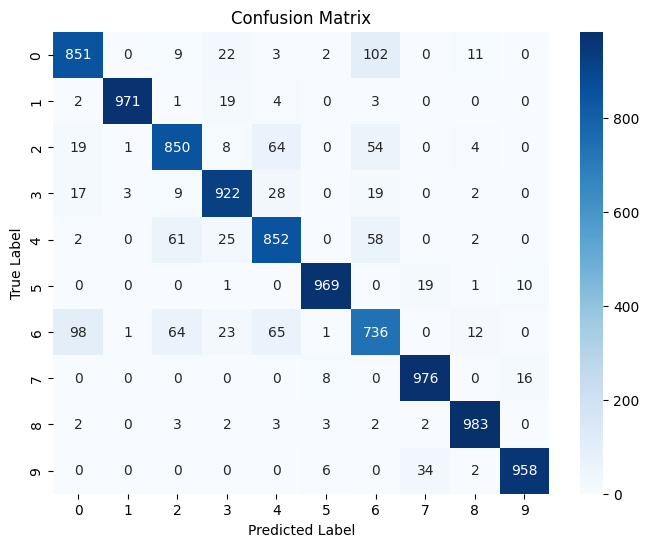

In [ ]:
# Confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

It reduced the missclassification between the classes between like 20 values, which is a good improvement from the previous ones

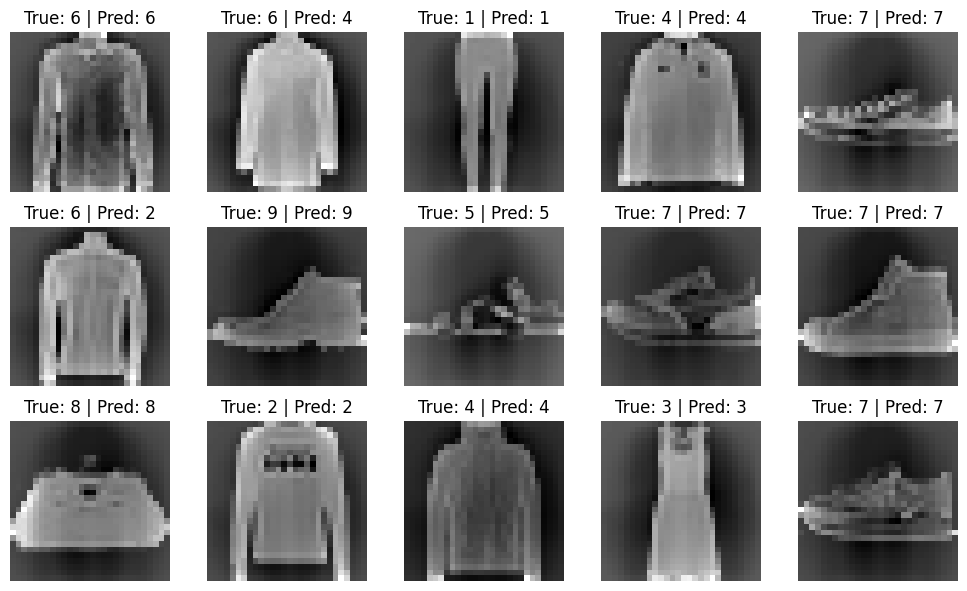

In [ ]:
# Predictions images with the true values
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
indices = np.random.choice(len(x_test), 15, replace=False)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = x_test[idx].reshape(28, 28)  # Restore
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {y_test[idx]} | Pred: {y_pred_final[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The model mostly classifies correctly, but some errors occur indicating potential areas for improvement.

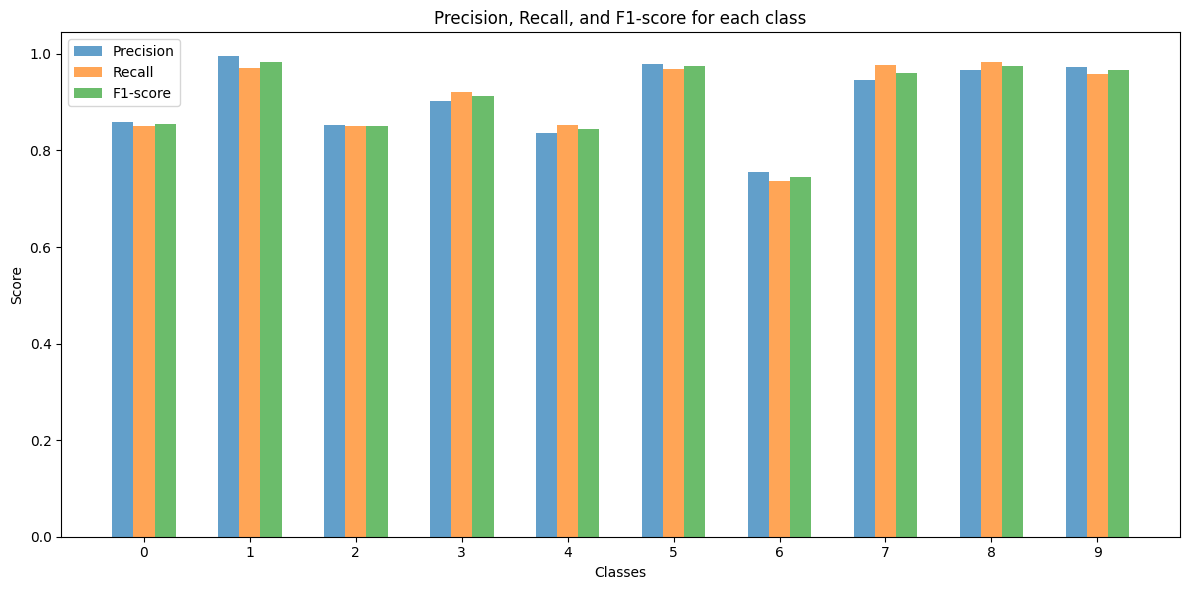

In [ ]:
# Bar plot visualization of each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_final, average=None)
labels = np.arange(10) # Change to numerical for better control

width = 0.2  # Set width of the bars

plt.figure(figsize=(12, 6)) # Adjusted figure size for better visualization

# Plotting each group of bars for precision, recall, and F1-score for each class
plt.bar(labels - width, precision, width, label='Precision', alpha=0.7)
plt.bar(labels, recall, width, label='Recall', alpha=0.7)
plt.bar(labels + width, f1, width, label='F1-score', alpha=0.7)

plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(labels, labels) # Ensure x-ticks align with the labels
plt.legend()
plt.title("Precision, Recall, and F1-score for each class")
plt.tight_layout()
plt.show()

In this visualisations we can see the different bar plot metrics for each class classification and their metrics, here we can see also the classes that are mainly missclassified and which ones are showing a better performance overall.